# Homework 03
__姓名__ 钱振天 __学号__ 21610045

## task 01
Generate sampling points from a 2D Gaussian distribution
### 产生一维正态分布

我们已知一维正态分布的概率密度函数为
$$
p(x|\mu,\sigma^2)=\frac{1}{\sqrt{2\pi}\cdot\sigma}e^{-{(x-\mu)}^2/(2\sigma^2)}
$$
则其概率分布函数为
$$
F_{\mu, \sigma^2}(x)=\int\nolimits_{-\inf}^x p(z|\mu,\sigma^2) dz \
$$
如果u满足正态分布
$$
u \sim Uniform(0, 1)
$$
则求解方程
$$
F_{\mu, \sigma^2}(x) = u 
$$
所得的解即为正态分布
$$
x = F_{\mu, \sigma^2}^{-1}(x)
$$

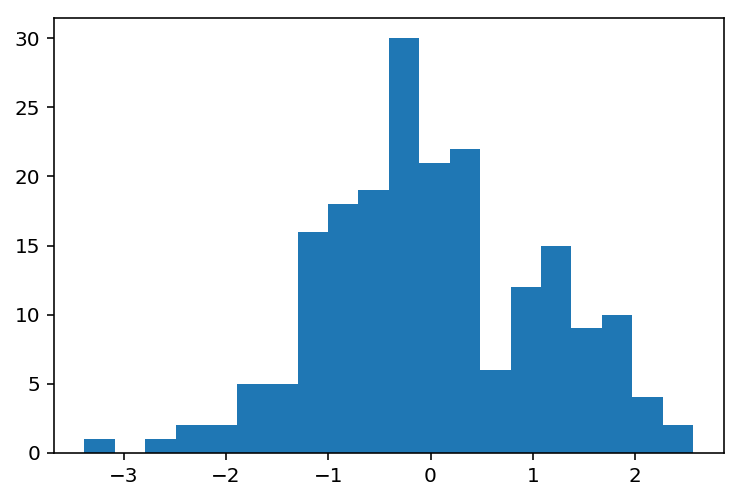

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy.linalg import sqrtm

import numpy as np
def pd(x):
    return 1.0/np.sqrt(2*np.pi)*np.exp(-np.square(x)/2)

def f(x,*args):
    
    u = args[0]    
    I = quad(pd, -np.inf, x)  
    return I[0] - u

N_1 = 200;
u1 = np.random.random_sample((2, N_1))
z1 = np.empty((2, N_1))
for i in range(N_1):
    z1[0, i] = fsolve(f, 0, u1[0, i])

plt.figure(1)
n,bins,patches = plt.hist(z1[0, :],20)  
   

### 产生二维正态分布
设有两维独立分布
$$
\mathbf{z} = [z_1, z_2]^T\quad E{(\mathbf{z})} = 0\quad cov(\mathbf{z}) = I
$$
令
$$
\mathbf{x} = \mathbf{Az} + \mathbf{\mu}
$$
对于二维正态分布的均值要求，即
$$
E{\mathbf{(x)}} = \mathbf{\mu}
$$
上式显然满足
接着我们计算方差，我们得到：
$$
cov(\mathbf{x}) = \mathbf{AA}^T=\Sigma
$$
令$\mathbf{A}$为对称阵，则
$$
x = \mathbf{\Sigma^{1/2}z} + \mathbf{\mu}
$$

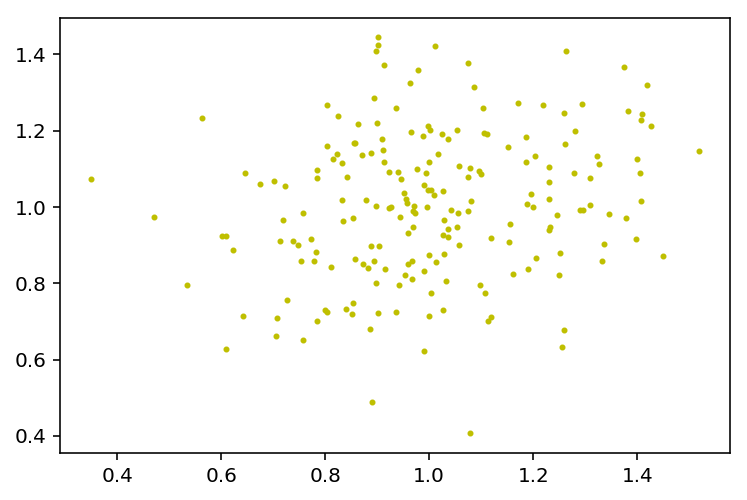

In [3]:
for i in range(N_1):
    z1[1, i] = fsolve(f, 0, u1[1, i])

mu1 = np.array([[1],[1]])
Sigma1 = np.array([[0.04, 0.01],[0.01, 0.04]])
x1 = np.matmul(sqrtm(Sigma1), z1) + mu1
plt.figure(2)
plt.plot(x1[0,:], x1[1,:], 'yo',markersize=2) 

## task 02
Generate sampling points from a 2D Mixture of Gaussian (MOG) distribution

假设模型中有两类正态分布
$$
\mu_1 = \begin{bmatrix}
1 & 1 
\end{bmatrix}\quad
\Sigma_1=\begin{bmatrix}
0.04 & 0.01 \\
0.01 & 0.04
\end{bmatrix}\quad
\mu_2 = \begin{bmatrix}
0 & 0 
\end{bmatrix}\quad
\Sigma_2=\begin{bmatrix}
0.04 & -0.01 \\
-0.01 & 0.04
\end{bmatrix}
$$
且两类正态分布的先验概率为
$$
P(y_i = 1) = \frac{2}{3}\quad
P(y_i = 2) = \frac{1}{3}
$$

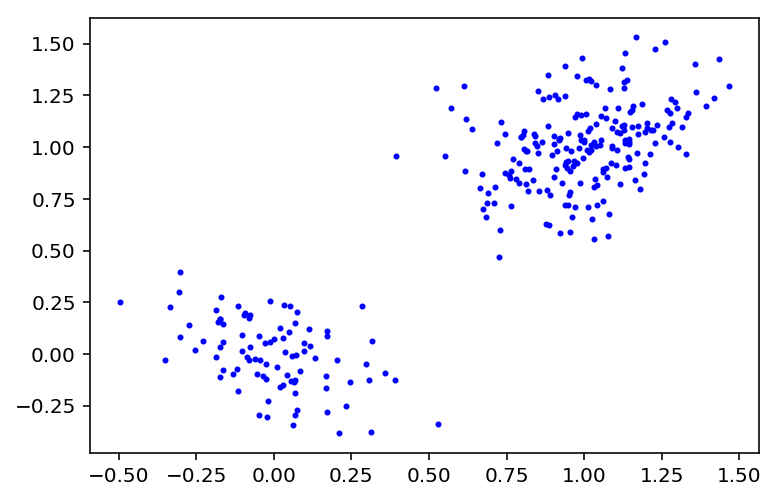

In [3]:
N_sample = 300;
u = np.random.random_sample((2, N_sample))
index = np.random.random_sample(N_sample)

mu2 = np.array([[0],[0]])
Sigma2 = np.array([[0.04, -0.01],[-0.01, 0.04]])
z = np.empty((2, N_sample))
x = np.empty((2, N_sample))

for i in range(N_sample):
    z[0, i] = fsolve(f, 0, u[0, i])

for i in range(N_sample):
    z[1, i] = fsolve(f, 0, u[1, i])

x[:,index >  (1.0/3.0)] = np.matmul(sqrtm(Sigma1), z[:,index >  (1.0/3.0)]) + mu1
x[:,index <= (1.0/3.0)] = np.matmul(sqrtm(Sigma2), z[:,index <= (1.0/3.0)]) + mu2

plt.figure(3)
plt.plot(x[0,:], x[1,:], 'bo',markersize=2) 

## task 03
Estimate parameters of generated data via step2 by using the E-M method
## task 04
Plot iteration results

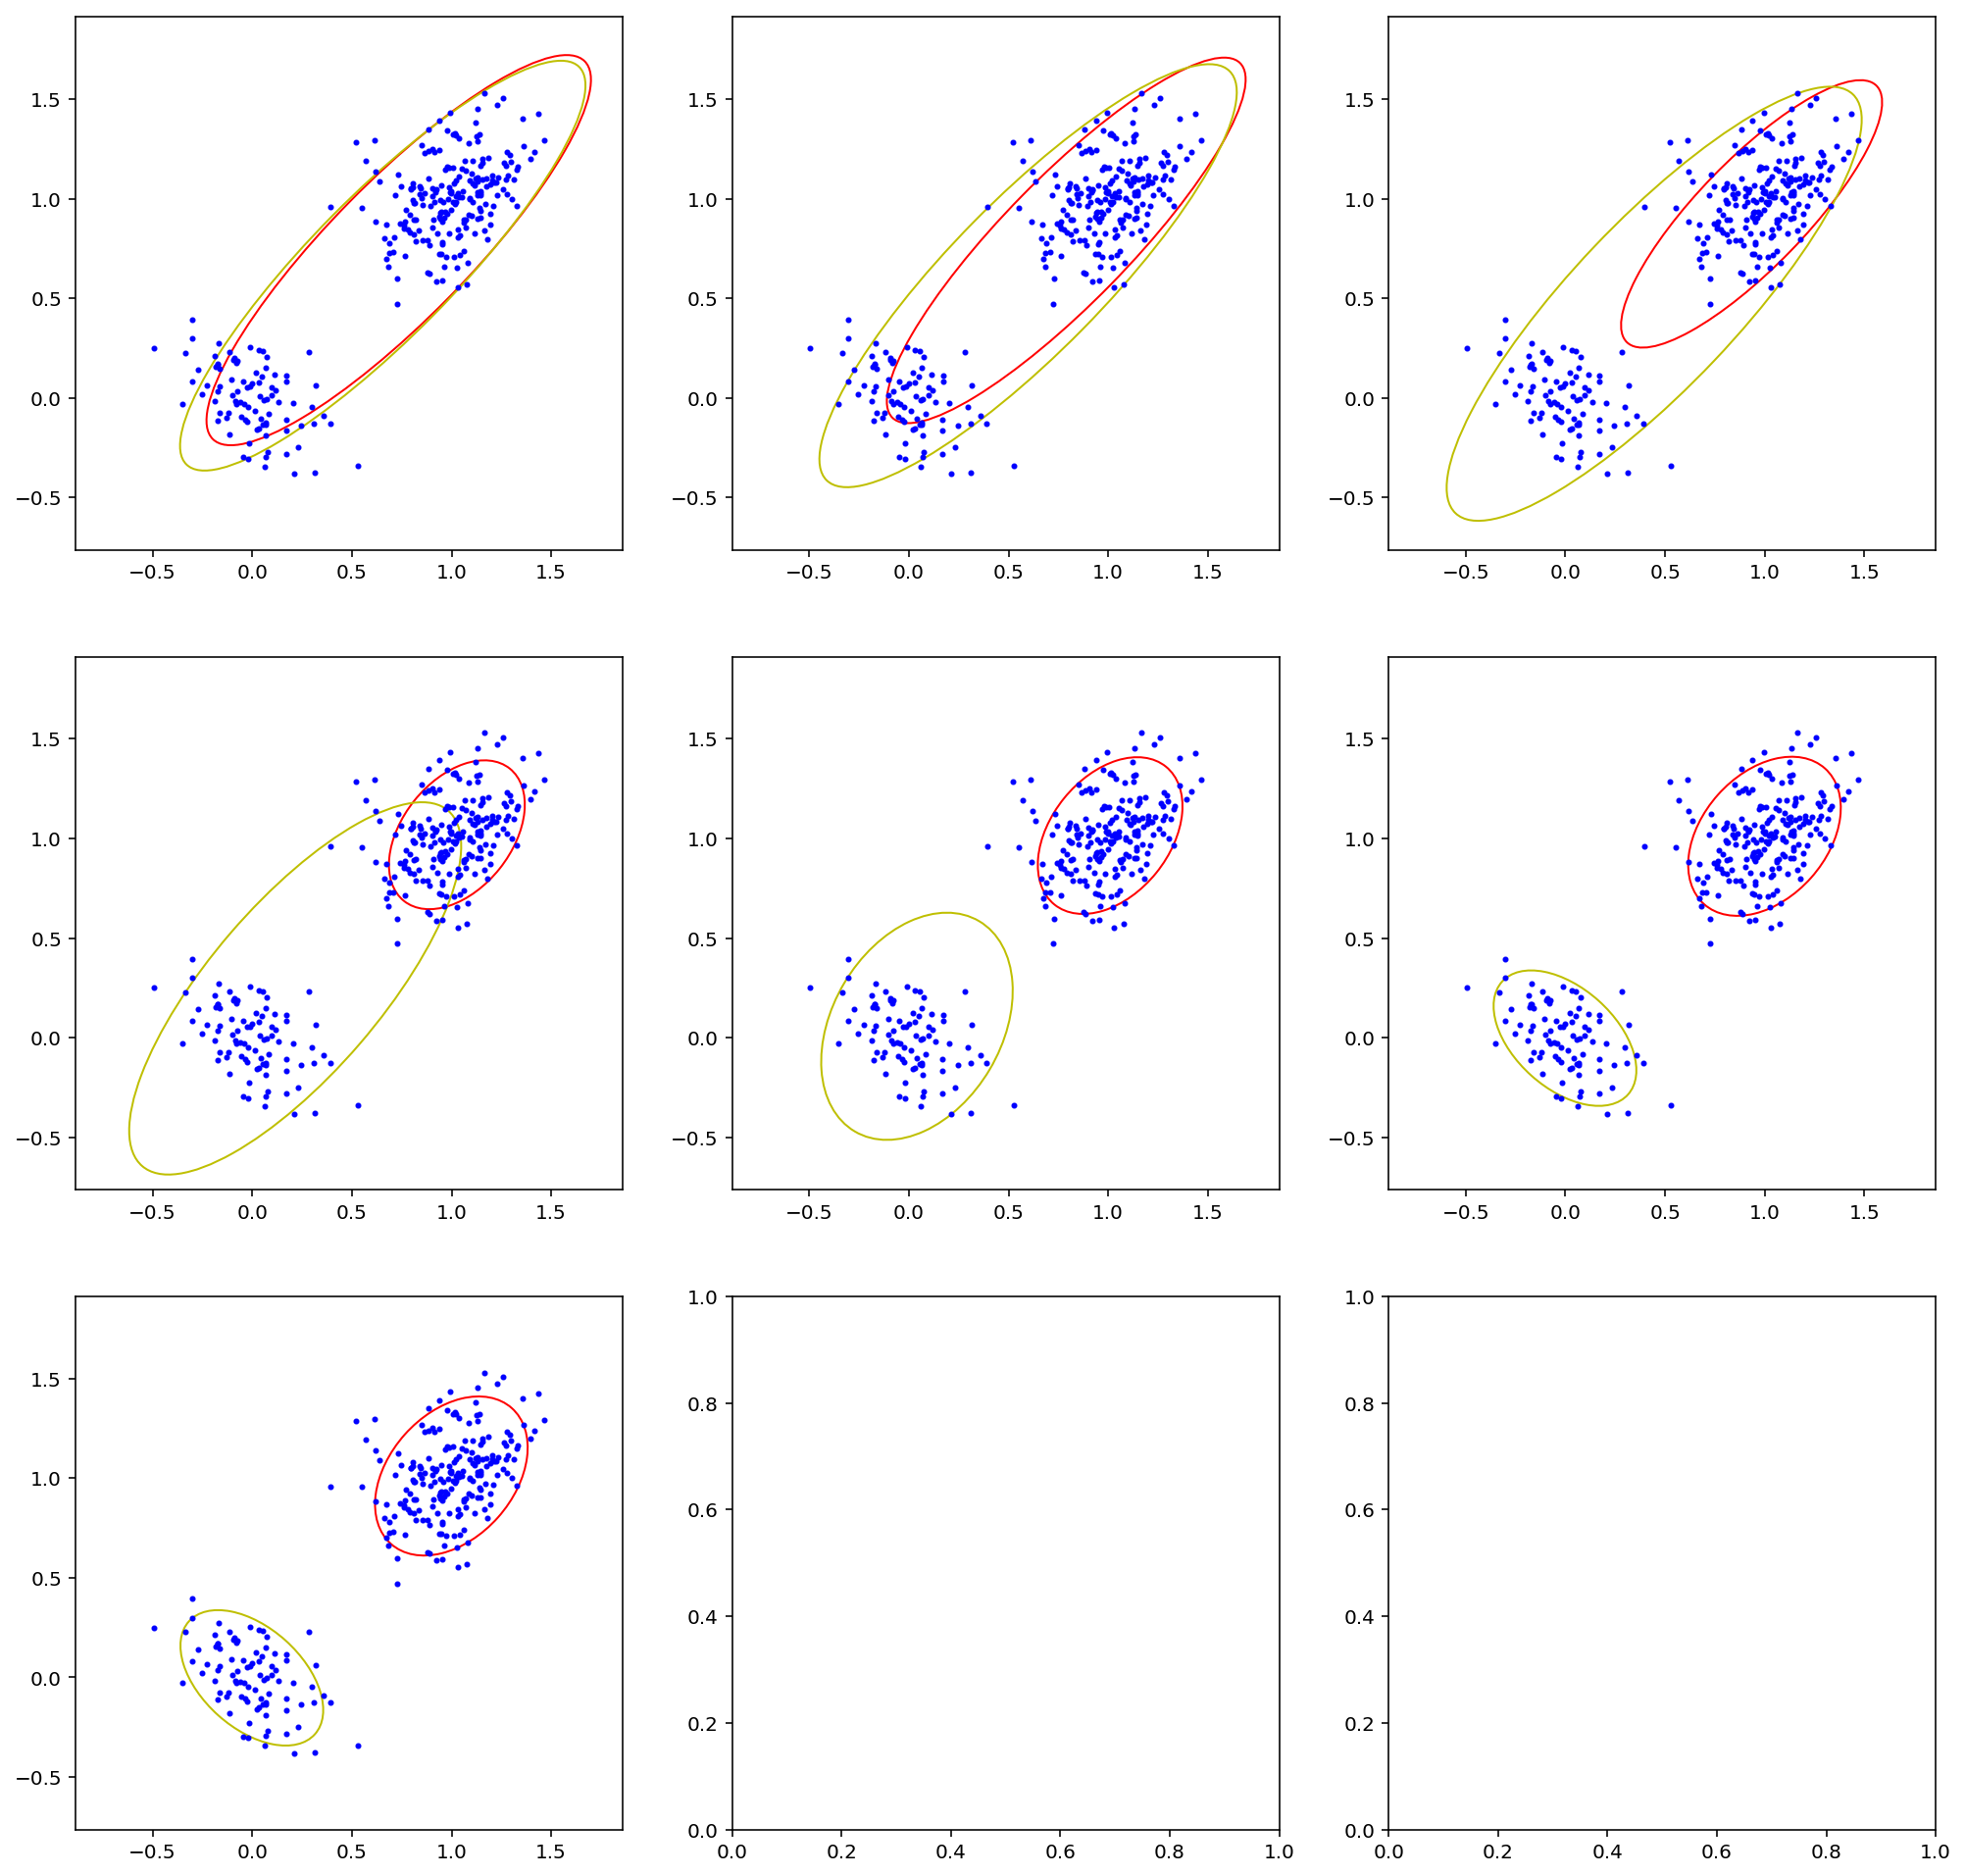

In [116]:
#initialization
pj = 0.5*np.ones(2)

index1 = np.random.randint(2, size=N_sample)

mu_est1 = np.mean(x[:,   index1], axis =1, keepdims = True)
mu_est2 = np.mean(x[:, 1-index1], axis =1, keepdims = True)

Sigma_est1 = np.diag(np.diag(np.cov(x[:,   index1])))
Sigma_est2 = np.diag(np.diag(np.cov(x[:, 1-index1])))

likelihood_new = -np.inf
likelihood_old = -np.inf

iteration  = 0
figure_num = 0

from numpy.linalg import det, inv
from matplotlib.patches import Ellipse

def pd2(t, mu, Sigma):
    return 1.0/np.sqrt(det(Sigma))/2/np.pi*np.exp(-0.5*np.sum(np.matmul((t - mu).T, inv(Sigma))*(t - mu).T, axis = 1))

px_thete = np.empty((2, N_sample))

f, axarr = plt.subplots(3,3, figsize=(17,17))
while iteration<= 25 and likelihood_new >= likelihood_old:
    # E-step
    px_thete[0, :] = pd2(x,mu_est1,Sigma_est1)*pj[0]
    px_thete[1, :] = pd2(x,mu_est2,Sigma_est2)*pj[1]
    px_theta_sum = np.sum(px_thete,axis = 0, keepdims= True)
    pji = px_thete / px_theta_sum
    
    # M-step
    nj = np.sum(pji,axis = 1, keepdims=True)
    pj = nj/N_sample
    mu_est1 = np.sum(pji[0,:] * x,axis = 1,keepdims = True)/nj[0]
    mu_est2 = np.sum(pji[1,:] * x,axis = 1,keepdims = True)/nj[1]
    #print('mu_est1', mu_est1,'\n')
    Sigma_est1 = np.matmul(pji[0,:] * (x - mu_est1),(x - mu_est1).T)/nj[0]
    Sigma_est2 = np.matmul(pji[1,:] * (x - mu_est2),(x - mu_est2).T)/nj[1]
    #print('Sigma_est1', Sigma_est1,'\n')
    likelihood_old = likelihood_new
    likelihood_new = np.sum(np.log(px_theta_sum))
    if iteration % 3 == 0:
        lambda1_, v1 = np.linalg.eig(Sigma_est1)
        lambda1_ = np.sqrt(lambda1_)
        e1 = Ellipse(xy=mu_est1,width=4*lambda1_[0], height=4*lambda1_[1],angle=np.rad2deg(np.arctan2(v1[1, 0], v1[0, 0])), color = 'r')
        e1.set_facecolor('none')

        lambda2_, v2 = np.linalg.eig(Sigma_est2)
        lambda2_ = np.sqrt(lambda2_)
        e2 = Ellipse(xy=mu_est2,width=4*lambda2_[0], height=4*lambda2_[1],angle=np.rad2deg(np.arctan2(v2[1, 0], v2[0, 0])), color = 'y')
        e2.set_facecolor('none')

        axarr[figure_num // 3,figure_num % 3].plot(x[0,:], x[1,:], 'bo',markersize=2) 
        axarr[figure_num // 3,figure_num % 3].add_artist(e1)
        axarr[figure_num // 3,figure_num % 3].add_artist(e2)
        axarr[figure_num // 3,figure_num % 3].margins(0.2)  
        figure_num = figure_num + 1
        
    iteration = iteration + 1

## implement MOG in n-D case
以三维正态分布为例

假设模型中有四类正态分布
$$
\mu_1 = \begin{bmatrix}
0 & 0 & 0 
\end{bmatrix}\quad
\Sigma_1=\begin{bmatrix}
0.04 & 0.01 & 0.01\\
0.01 & 0.04 & 0.01\\
0.01 & 0.01 & 0.04
\end{bmatrix}\quad
$$

$$
\mu_2 = \begin{bmatrix}
1 & 1 & 1 
\end{bmatrix}\quad
\Sigma_2=\begin{bmatrix}
0.04 & -0.01 & 0.01\\
-0.01 & 0.04 & 0.01\\
0.01 & 0.01 & 0.04
\end{bmatrix}
$$

$$
\mu_3 = \begin{bmatrix}
1 & 1 & 0 
\end{bmatrix}\quad
\Sigma_3=\begin{bmatrix}
0.04 & 0.01 & 0.01\\
0.01 & 0.04 & -0.01\\
0.01 & -0.01 & 0.04
\end{bmatrix}
$$

$$
\mu_4 = \begin{bmatrix}
0 & 0 & 1 
\end{bmatrix}\quad
\Sigma_4=\begin{bmatrix}
0.04 & 0.01 & -0.01\\
0.01 & 0.04 & 0.01\\
-0.01 & 0.01 & 0.04
\end{bmatrix}
$$

且四类正态分布的先验概率为
$$
P(y_i = 1) = \frac{1}{4}\quad
P(y_i = 2) = \frac{1}{4}\quad
P(y_i = 3) = \frac{1}{4}\quad
P(y_i = 4) = \frac{1}{4}
$$

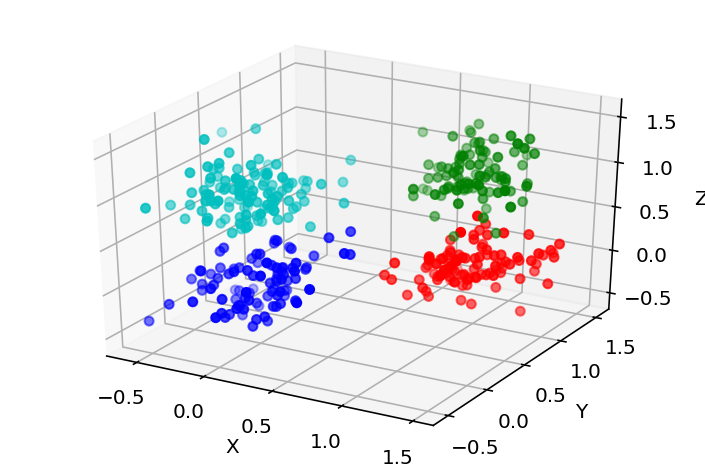

In [4]:
from mpl_toolkits.mplot3d import Axes3D
N_data = 400;
N_dim = 3;
N_cluster = 4;

u = np.random.random_sample((N_dim, N_data))
index = np.random.randint(low = 0, high = N_cluster, size=N_data)

mu = np.empty((N_cluster,N_dim,1))
mu[0,:,:] = np.array([[0], [0], [0]])
mu[1,:,:] = np.array([[1], [1], [1]])
mu[2,:,:] = np.array([[1], [1], [0]])
mu[3,:,:] = np.array([[0], [0], [1]])

Sigma = np.empty((N_cluster, N_dim, N_dim))
Sigma[0,:,:] = np.array([[0.04,  0.01,  0.01],[ 0.01, 0.04,  0.01], [ 0.01,  0.01, 0.04]])
Sigma[1,:,:] = np.array([[0.04, -0.01,  0.01],[-0.01, 0.04,  0.01], [ 0.01,  0.01, 0.04]])
Sigma[2,:,:] = np.array([[0.04,  0.01,  0.01],[ 0.01, 0.04, -0.01], [ 0.01, -0.01, 0.04]])
Sigma[3,:,:] = np.array([[0.04,  0.01, -0.01],[ 0.01, 0.04,  0.01], [-0.01,  0.01, 0.04]])

u_n = np.random.random_sample((N_dim, N_data))
z_n = np.empty((N_dim, N_data))
x_n = np.empty((N_dim, N_data))

for j in range(N_dim):
    for i in range(N_data):
        z_n[j, i] = fsolve(f, 0, u_n[j, i])

for k in range(N_cluster):
    x_n[:,index == k] = np.matmul(sqrtm(Sigma[k,:,:]), z_n[:,index == k]) + mu[k,:,:]

color_char = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
ax = plt.subplot(111, projection='3d')  # 创建一个三维的绘图工程
for k in range(N_cluster):
    ax.scatter(x_n[0,index == k], x_n[1,index == k], x_n[2,index == k], c=color_char[k])  # 绘制数据点

ax.set_zlabel('Z')  # 坐标轴
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.show()




### E-M in n-D case

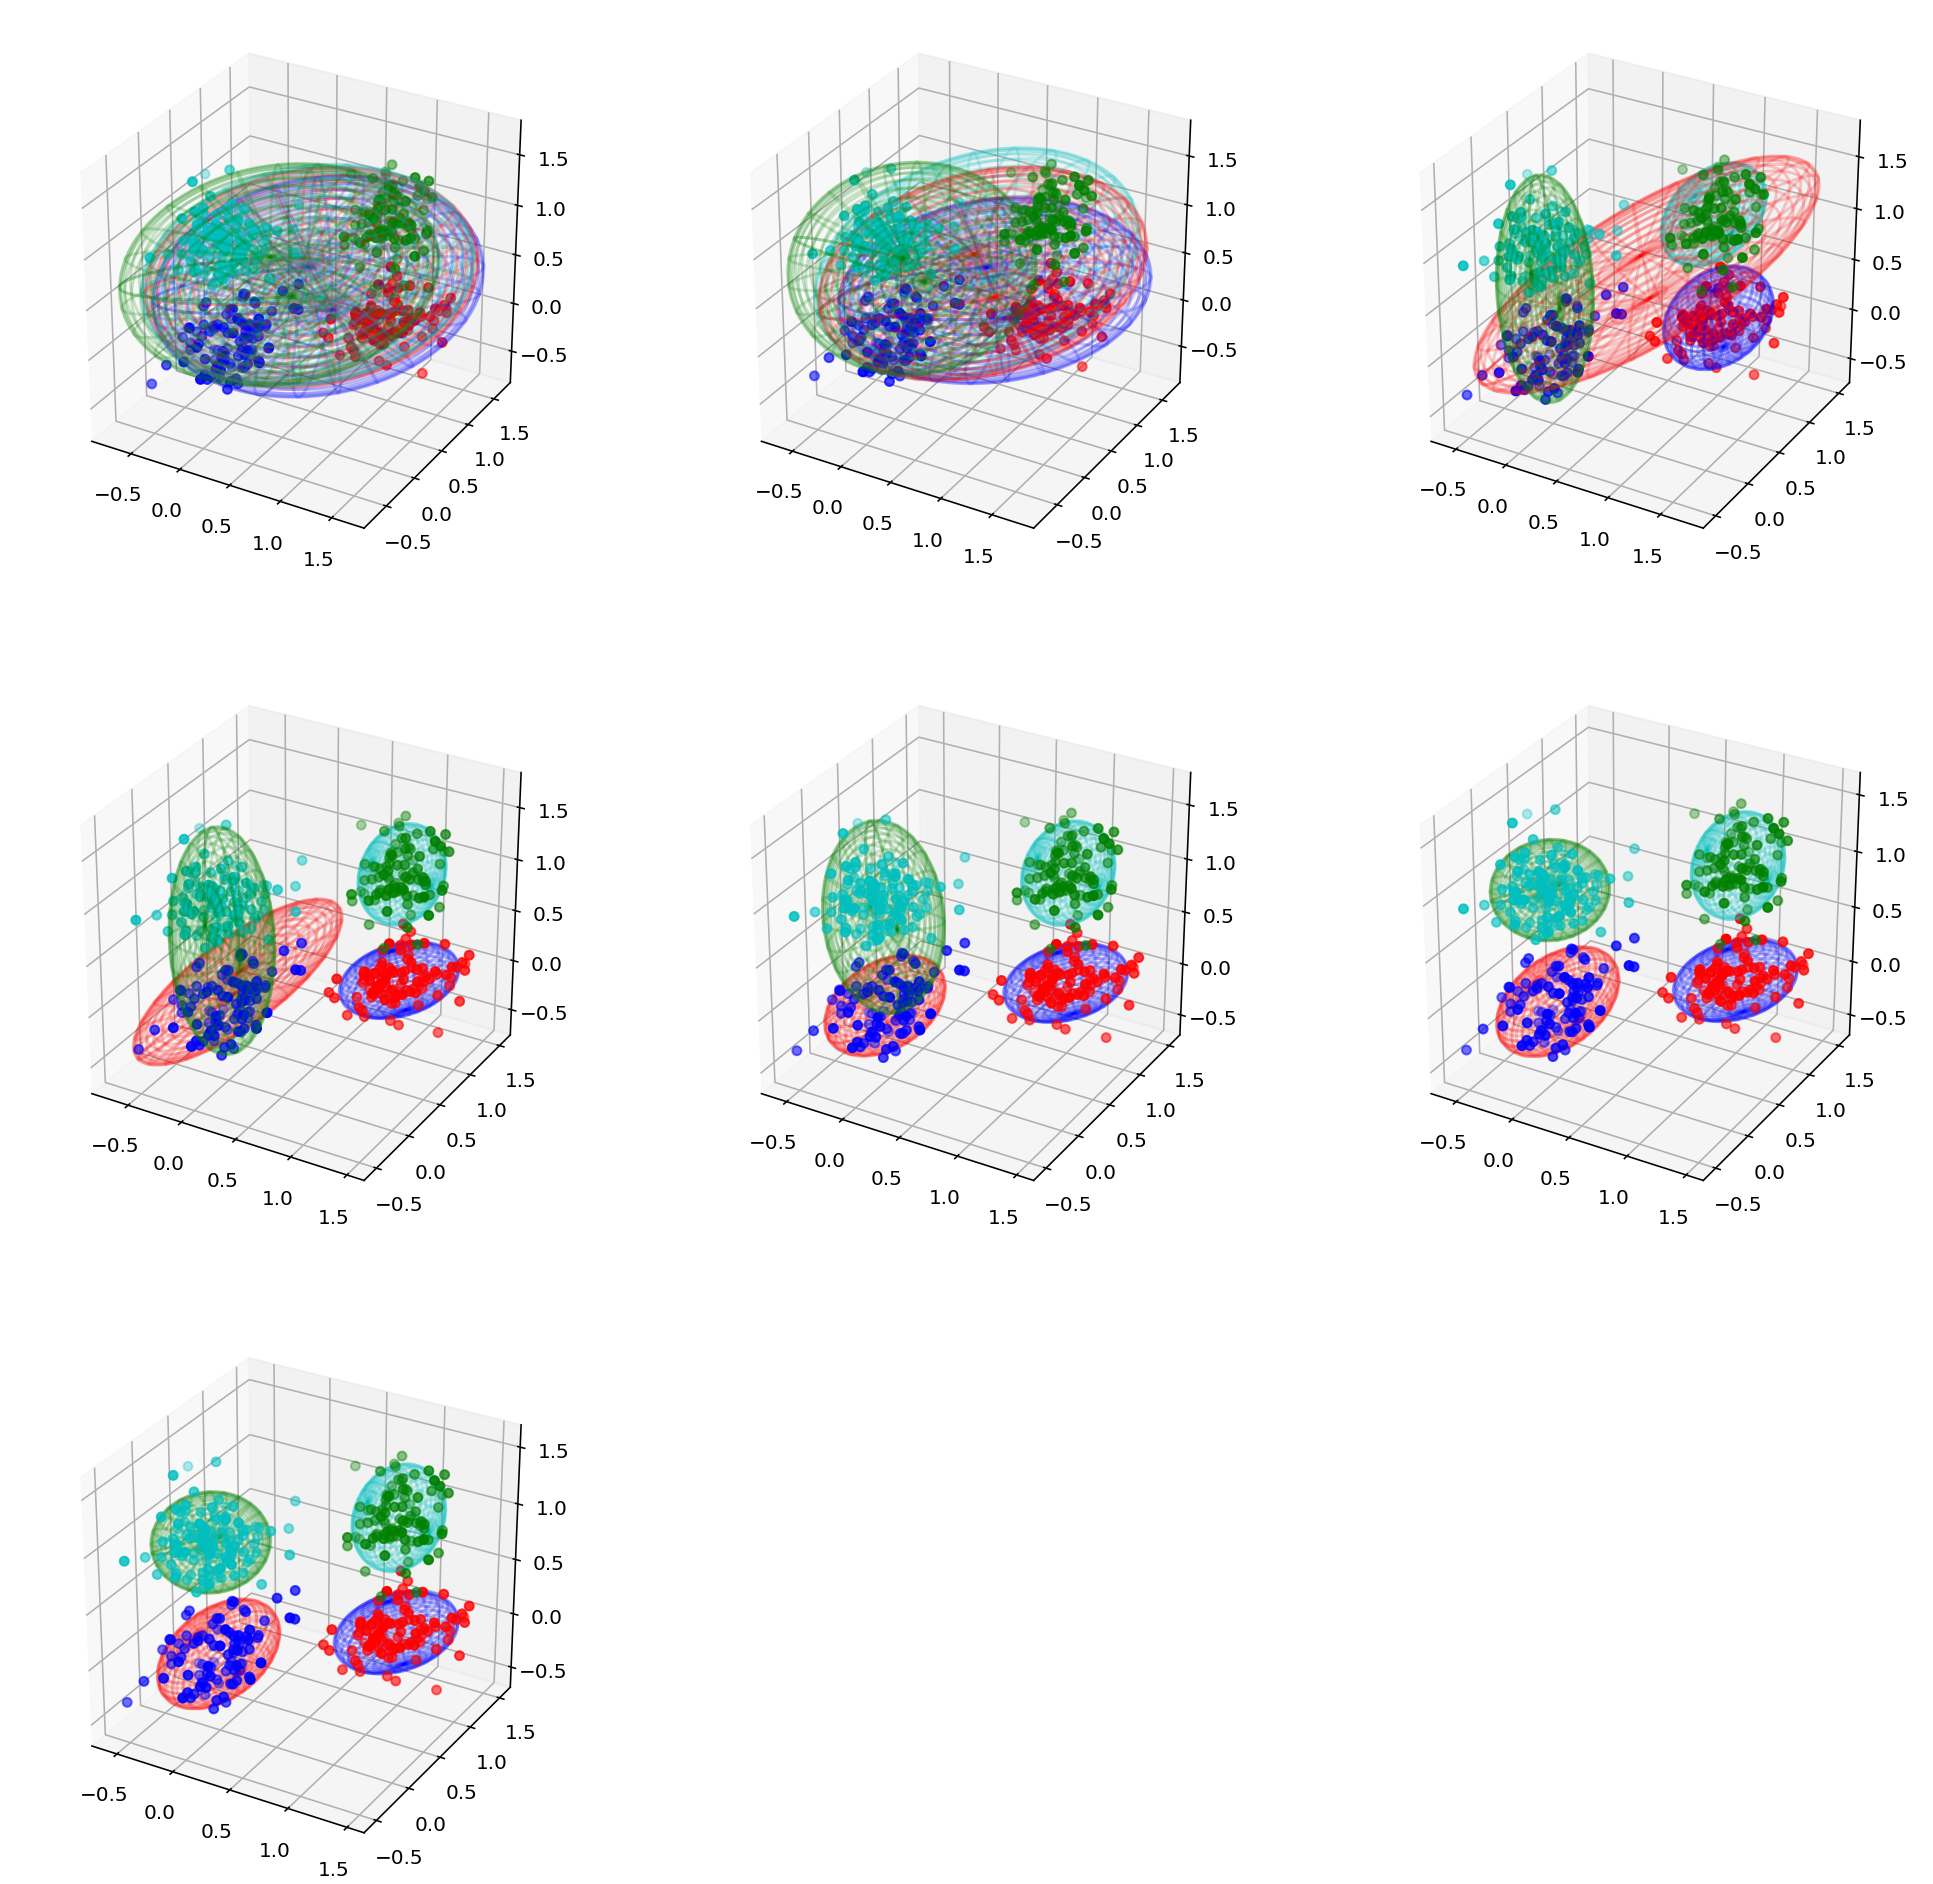

In [36]:
#initialization
from mpl_toolkits.mplot3d import Axes3D
pj = 1.0/N_cluster*np.ones(N_cluster)

index1 = np.random.randint(low = 0, high = N_cluster, size=N_data)

mu_est = np.empty((N_cluster,N_dim,1))
Sigma_est = np.empty((N_cluster, N_dim, N_dim))

for k in range(N_cluster):
    mu_est[k,:,:] =  np.mean(x_n[:, index1 == k], axis =1, keepdims = True)
    Sigma_est[k,:,:] = np.diag(np.diag(np.cov(x_n[:, index1 == k])))

likelihood_new = -np.inf
likelihood_old = -np.inf

iteration  = 0
figure_num = 0

from numpy.linalg import det, inv
from matplotlib.patches import Ellipse

# points on unit sphere
coordinate_3ds = np.empty((3,100,100))

u = np.linspace(0.0, 2.0 * np.pi, 100)
v = np.linspace(0.0, np.pi, 100)

coordinate_3ds[0,:,:] = np.outer(np.cos(u), np.sin(v))
coordinate_3ds[1,:,:] = np.outer(np.sin(u), np.sin(v))
coordinate_3ds[2,:,:] = np.outer(np.ones_like(u), np.cos(v))

def plot_ellipsoid_3d(center, A):
    #Plot the 3-d Ellipsoid ell on the Axes3D ax.#
    # transform points to ellipsoid\
    coordinate_3de = np.empty((3,100,100))
    U, s, rotation =  np.linalg.svd(A)
    radii = 2*np.sqrt(s)
    coordinate_3de = np.expand_dims(np.expand_dims(radii, axis=1), axis=2)*coordinate_3ds
    for i in range(len(u)):
        for j in range(len(u)):
            coordinate_3de[:,i,j] = center.T + np.matmul(np.expand_dims(coordinate_3de[:,i,j], axis=0),rotation)
    coordinate_3de.shape
    return coordinate_3de

def pdn(t, mu, Sigma):
    return 1.0/np.sqrt(det(Sigma))/np.power(np.pi*2, N_dim/2.0)*np.exp(-0.5*np.sum(np.matmul((t - mu).T, inv(Sigma))*(t - mu).T, axis = 1))

px_thete = np.empty((N_cluster, N_data))

fig = plt.figure(figsize=(17,17))
figure_num = 1
while iteration<= 70 and likelihood_new >= likelihood_old:
    # E-step
    for k in range(N_cluster):
        px_thete[k, :] = pdn(x_n,mu_est[k,:,:],Sigma_est[k,:,:])*pj[k]
    
    px_theta_sum = np.sum(px_thete,axis = 0, keepdims= True)
    pji = px_thete / px_theta_sum
    
    # M-step
    nj = np.sum(pji,axis = 1, keepdims=True)
    pj = nj/N_data
    
    for k in range(N_cluster):
        mu_est[k,:,:] = np.sum(pji[k,:] * x_n,axis = 1,keepdims = True)/nj[k]
        Sigma_est[k,:,:] = np.matmul(pji[k,:] * (x_n - mu_est[k,:,:]),(x_n - mu_est[k,:,:]).T)/nj[k]
        
    likelihood_old = likelihood_new
    likelihood_new = np.sum(np.log(px_theta_sum))
    
    if iteration % 8 == 0:
        #axarr[figure_num // 3,figure_num % 3].margins(0.2)  
        ax = fig.add_subplot(3, 3, figure_num, projection='3d')
        for k in range(N_cluster):
            ax.scatter(x_n[0,index == k], x_n[1,index == k], x_n[2,index == k], c=color_char[k])  # 绘制数据点
            coordinate_3d = plot_ellipsoid_3d(mu_est[k,:,:], Sigma_est[k,:,:])
            ax.plot_wireframe(coordinate_3d[0,:,:], coordinate_3d[1,:,:], coordinate_3d[2,:,:],  rstride=4, cstride=4, color=color_char[k], alpha=0.2)
        figure_num = figure_num + 1
        
    iteration = iteration + 1

### add regularization term

在EM算法中加入正则项，等效于将原来对于likelihood的最大化转换成对后验概率的最大化（MAP）
<font size=4>$$
P(\mathbf{\Sigma}, \mathbf{\mu}, \mathbf{\pi}|\mathbf{X}, \mathbf{Z})= \frac{P(\mathbf{X}, \mathbf{Z}|\mathbf{\Sigma}, \mathbf{\mu}, \mathbf{\pi})P(\mathbf{\Sigma})P(\mathbf{\mu})P(\mathbf{\pi})}{P(\mathbf{X}, \mathbf{Z})}
$$</font>

在这里，我们假设共有K种Component，N个数据点，数据维度为p，$P(\mathbf{\pi})$满足Dirichilet分布，$P(\mathbf{\mu})$满足均匀分布，$P(\mathbf{\Sigma})$满足Inverse Wishart分布，则
<font size=4>$$
P(\mathbf{\Sigma}, \mathbf{\mu}, \mathbf{\pi}|\mathbf{X},\mathbf{Z})\propto P(\mathbf{X},\mathbf{Z}|\mathbf{\Sigma}, \mathbf{\mu}, \mathbf{\pi})P(\mathbf{\Sigma})P(\mathbf{\pi})=\prod_{n=1}^N\prod_{k=1}^K\pi_k^{z_n^k}\mathcal{N}(x_n|\mu_k,\Sigma_k)^{z_n^k}\prod_{k=1}^KinverseWishart(p+2,V)Dirichlet(\mathbf{\pi},\mathbf{\alpha})
\\\propto\prod_{n=1}^N\prod_{k=1}^K\pi_k^{z_n^k}\left|\Sigma_k\right|^{-\frac{z_n^k}{2}}exp^{(-\frac{z_n^k}{2}trace(\Sigma_k^{-1}(x_n - \mu_k)(x_n - \mu_k)^T))}\prod_{k=1}^K\left|\Sigma_k\right|^{-\frac{2p+3}{2}}exp^{(-\frac{1}{2}trace(\Sigma_k^{-1}V^{-1}))}\prod_{k=1}^K\pi_k^{\alpha_k-1}
$$</font>
对上式求其对数关于$\mathbf{Z}$的期望，我们得到：
<font size=4>$$
E(log(P(\mathbf{\Sigma}, \mathbf{\mu}, \mathbf{\pi}|\mathbf{X},\mathbf{Z})))\propto\sum_{n=1}^N\sum_{k=1}^K\gamma(z_n^k)(log(\pi_k)-\frac{1}{2}log(\left|\Sigma_k\right|)-\frac{1}{2}trace(\Sigma_k^{-1}(x_n - \mu_k)(x_n - \mu_k)^T))+\\
\sum_{k=1}^K-\frac{2p+3}{2}log(\left|\Sigma_k\right|)-\frac{1}{2}trace(\Sigma_k^{-1}V^{-1})+(\alpha_k-1)log(\pi_k)
$$</font>
对上式求取极大值，也就是对$\mathbf{\mu}$，$\mathbf{\Sigma}$和$\mathbf{\pi}$求偏导，并计算出导数为零时的解。观察上式可知，$\mathbf{\mu}$的解保持不变，$\mathbf{\Sigma}$和$\mathbf{\pi}$的解会发生变化。其中：
<font size=4>$$
n_k = \sum_{n=1}^N\gamma(z_n^k)\\
\Sigma_k=\frac{\sum_{n=1}^N\gamma(z_n^k)(x_n - \mu_k)(x_n - \mu_k)^T + V^{-1}}{n_k + 2p + 3}\\
\pi_k=\frac{n_k+\alpha_k - 1}{N+\sum_{k=1}^K\alpha_k - K}
$$</font>

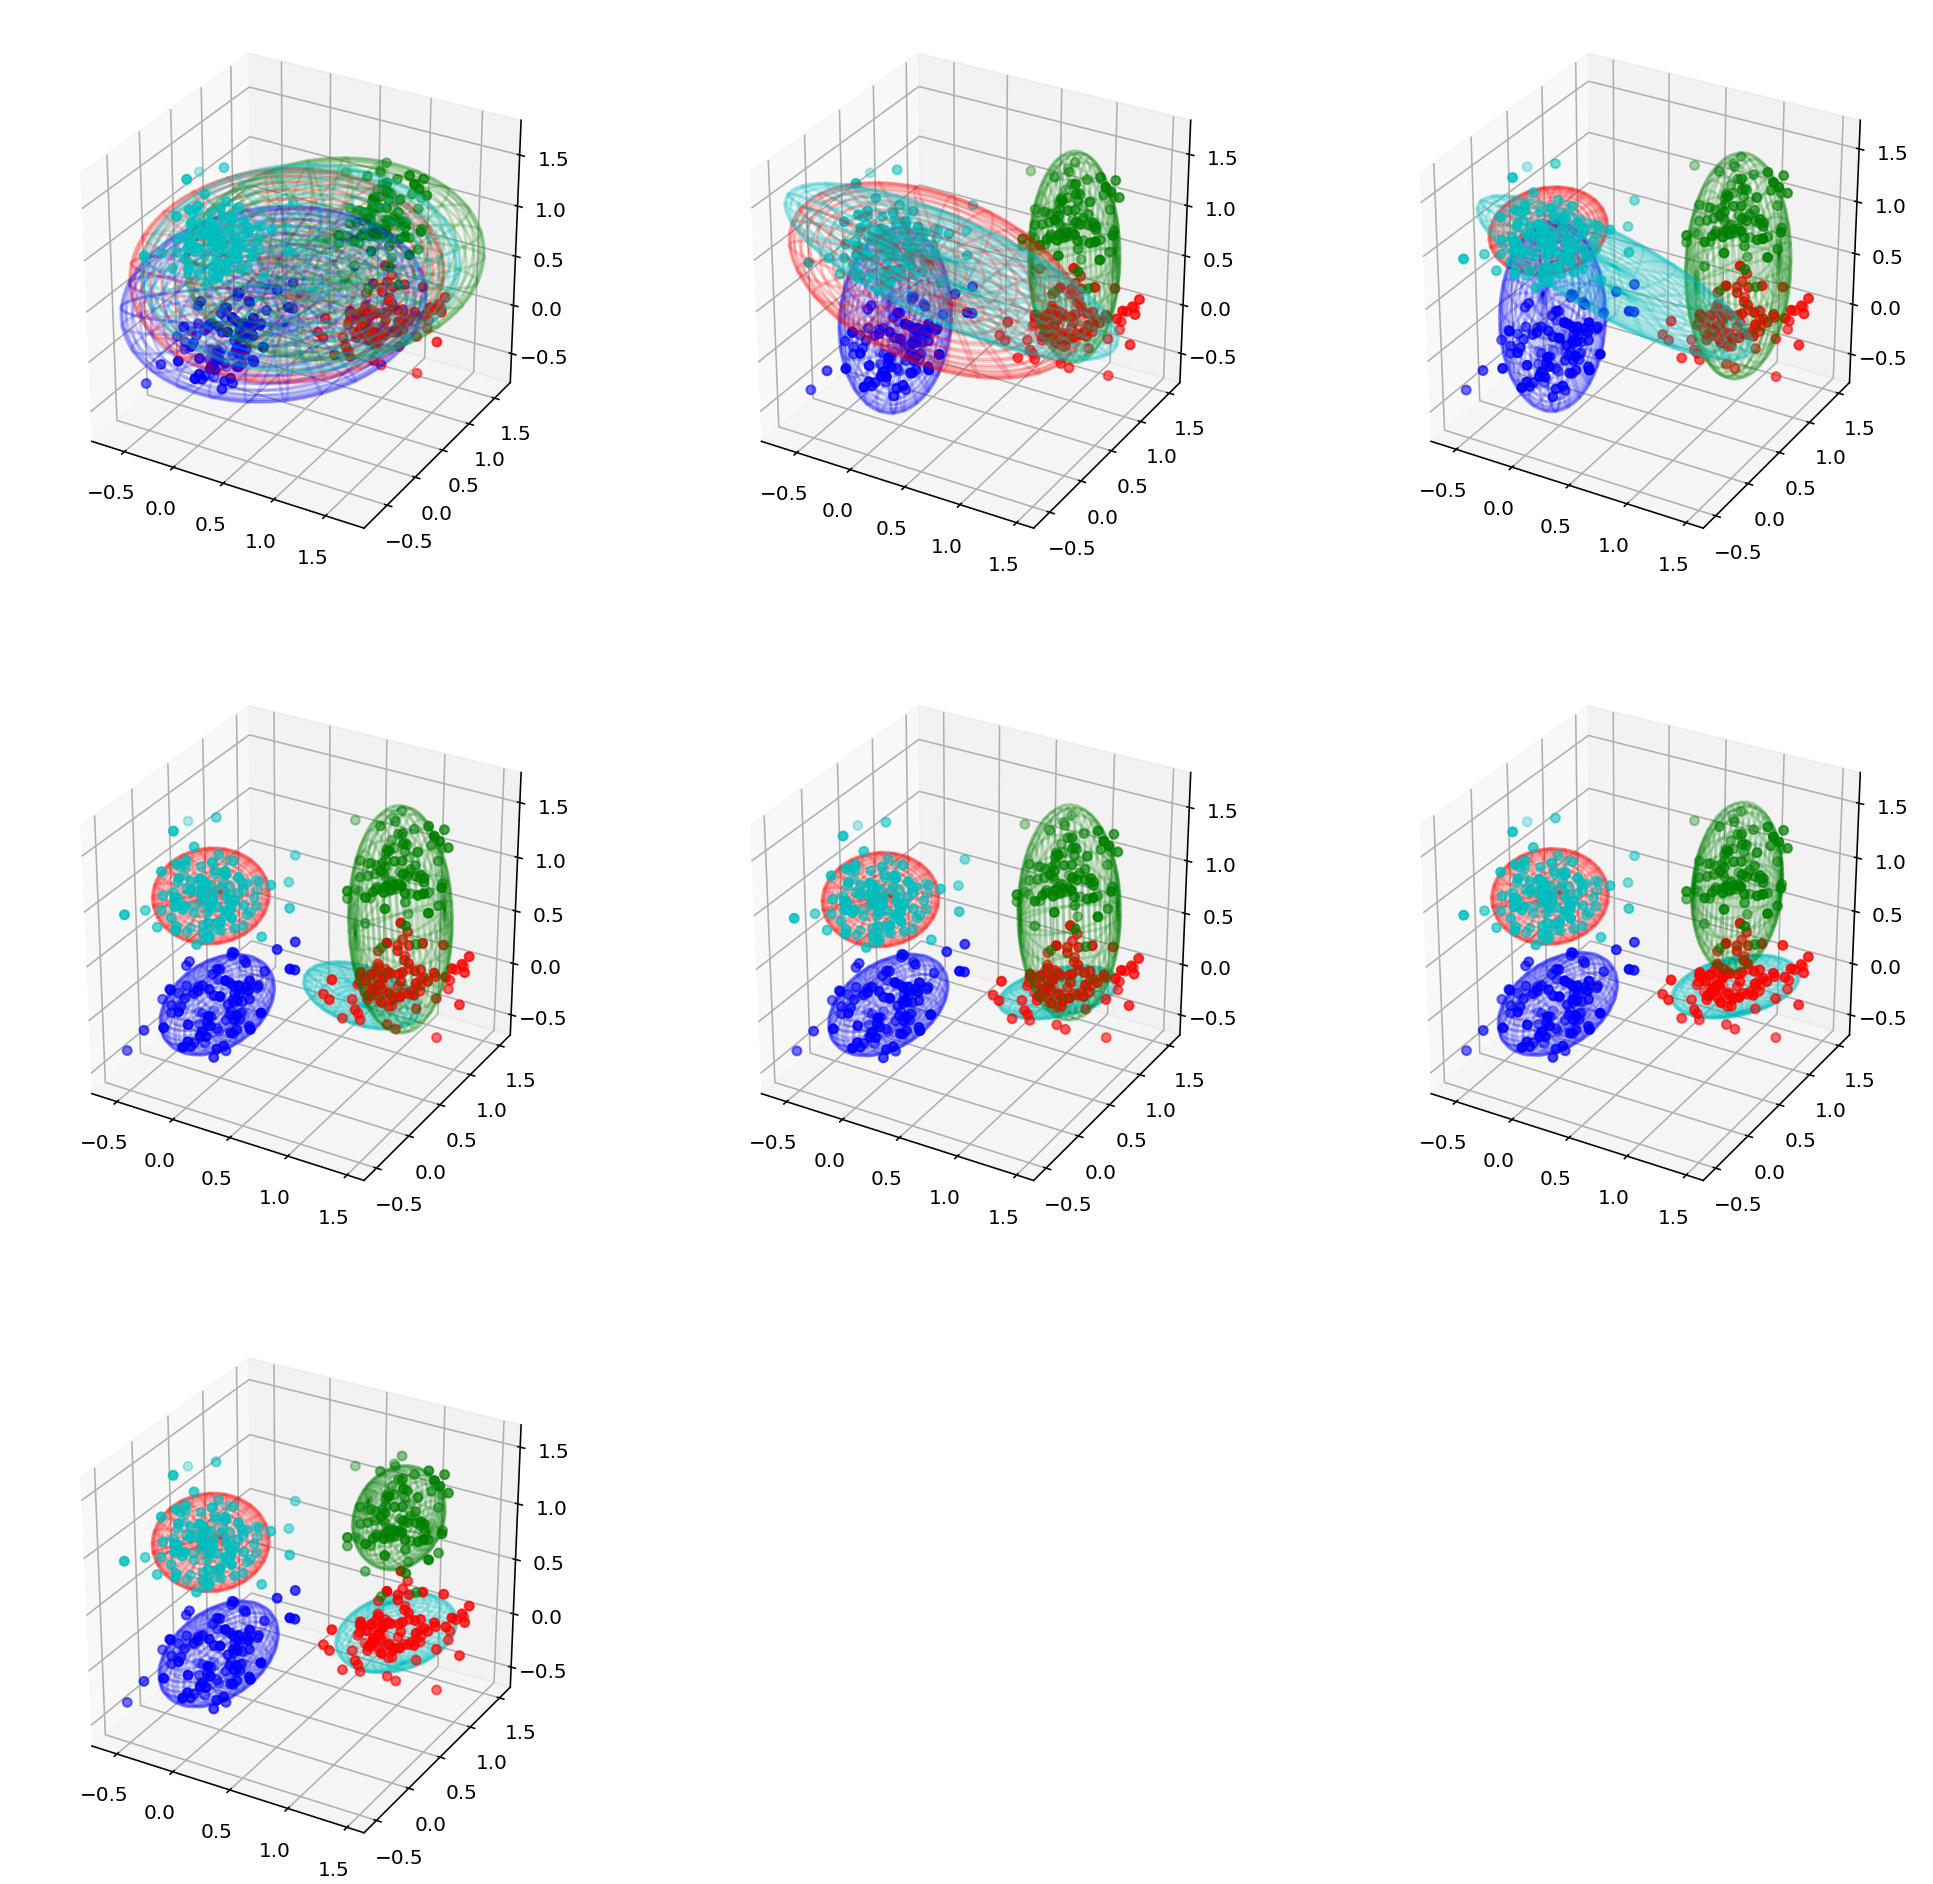

In [35]:
#initialization
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import det, inv
from matplotlib.patches import Ellipse
from scipy.stats import invwishart, dirichlet

pj = 1.0/N_cluster*np.ones(N_cluster)

index1 = np.random.randint(low = 0, high = N_cluster, size=N_data)

mu_est = np.empty((N_cluster,N_dim,1))
Sigma_est = np.empty((N_cluster, N_dim, N_dim))

V_inv = np.cov(x_n)/np.power(N_cluster,2/N_dim)
alpha = 2*np.ones((N_cluster,1));

for k in range(N_cluster):
    mu_est[k,:,:] =  np.mean(x_n[:, index1 == k], axis =1, keepdims = True)
    Sigma_est[k,:,:] = V_inv

likelihood_new = -np.inf
likelihood_old = -np.inf

iteration  = 0
figure_num = 0

# points on unit sphere
coordinate_3ds = np.empty((3,100,100))

u = np.linspace(0.0, 2.0 * np.pi, 100)
v = np.linspace(0.0, np.pi, 100)

coordinate_3ds[0,:,:] = np.outer(np.cos(u), np.sin(v))
coordinate_3ds[1,:,:] = np.outer(np.sin(u), np.sin(v))
coordinate_3ds[2,:,:] = np.outer(np.ones_like(u), np.cos(v))

def plot_ellipsoid_3d(center, A):
    #Plot the 3-d Ellipsoid ell on the Axes3D ax.#
    # transform points to ellipsoid\
    coordinate_3de = np.empty((3,100,100))
    U, s, rotation =  np.linalg.svd(A)
    radii = 2*np.sqrt(s)
    coordinate_3de = np.expand_dims(np.expand_dims(radii, axis=1), axis=2)*coordinate_3ds
    for i in range(len(u)):
        for j in range(len(u)):
            coordinate_3de[:,i,j] = center.T + np.matmul(np.expand_dims(coordinate_3de[:,i,j], axis=0),rotation)
    coordinate_3de.shape
    return coordinate_3de

def pdn(t, mu, Sigma):
    return 1.0/np.sqrt(det(Sigma))/np.power(np.pi*2, N_dim/2.0)*np.exp(-0.5*np.sum(np.matmul((t - mu).T, inv(Sigma))*(t - mu).T, axis = 1))

px_thete = np.empty((N_cluster, N_data))

fig = plt.figure(figsize=(17,17))
figure_num = 1
while iteration<= 70 and likelihood_new >= likelihood_old:
    # E-step
    for k in range(N_cluster):
        px_thete[k, :] = pdn(x_n,mu_est[k,:,:],Sigma_est[k,:,:])*pj[k]
    
    px_theta_sum = np.sum(px_thete,axis = 0, keepdims= True)
    pji = px_thete / px_theta_sum
    
    # M-step
    nj = np.sum(pji,axis = 1, keepdims=True)
    pj = (nj + alpha - 1)/(N_data + np.sum(alpha) - N_cluster)
    for k in range(N_cluster):
        mu_est[k,:,:] = np.sum(pji[k,:] * x_n,axis = 1,keepdims = True)/nj[k]
        Sigma_est[k,:,:] = (np.matmul(pji[k,:] * (x_n - mu_est[k,:,:]),(x_n - mu_est[k,:,:]).T) + V_inv)/(nj[k] + 2*N_dim + 3)
        
    likelihood_old = likelihood_new
    Sigma_inv = inv(Sigma_est)
    likelihood_new = np.sum(np.log(px_theta_sum)) \
    + np.sum(np.log(dirichlet.pdf(np.squeeze(pj),np.squeeze(alpha)))) \
    + np.sum(np.log(invwishart.pdf(np.moveaxis(Sigma_inv,0,2),df=N_dim + 2, scale=V_inv)))
    
    if iteration % 8 == 0:
        #axarr[figure_num // 3,figure_num % 3].margins(0.2)  
        ax = fig.add_subplot(3, 3, figure_num, projection='3d')
        for k in range(N_cluster):
            ax.scatter(x_n[0,index == k], x_n[1,index == k], x_n[2,index == k], c=color_char[k])  # 绘制数据点
            coordinate_3d = plot_ellipsoid_3d(mu_est[k,:,:], Sigma_est[k,:,:])
            ax.plot_wireframe(coordinate_3d[0,:,:], coordinate_3d[1,:,:], coordinate_3d[2,:,:],  rstride=4, cstride=4, color=color_char[k], alpha=0.2)
        figure_num = figure_num + 1
        
    iteration = iteration + 1